<a href="https://colab.research.google.com/github/alexiej/laboratory/blob/master/30_00_GAN_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Pillow==5.0.0
!pip install scipy==1.0.1

  Using cached https://files.pythonhosted.org/packages/2c/13/eb888fcc83f14d114dee794c3491477ce156caa9f456b7bef1112dde36b5/scipy-1.0.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.0.1 which is incompatible.
ERROR: cvxpy 1.0.25 has requirement scipy>=1.1.0, but you'll have scipy 1.0.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [14]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

print("Tensorflow version: ", tf.__version__)
print("Pytorch version: ", torch.__version__)
print("GPU ON: ", torch.cuda.is_available())
 
!nvidia-smi

Tensorflow version:  2.1.0
Pytorch version:  1.4.0
GPU ON:  True
Wed Mar  4 11:22:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:           

## 1.0 IMage to Image Conversion

Article: https://towardsdatascience.com/image-to-image-translation-using-cyclegan-model-d58cfff04755


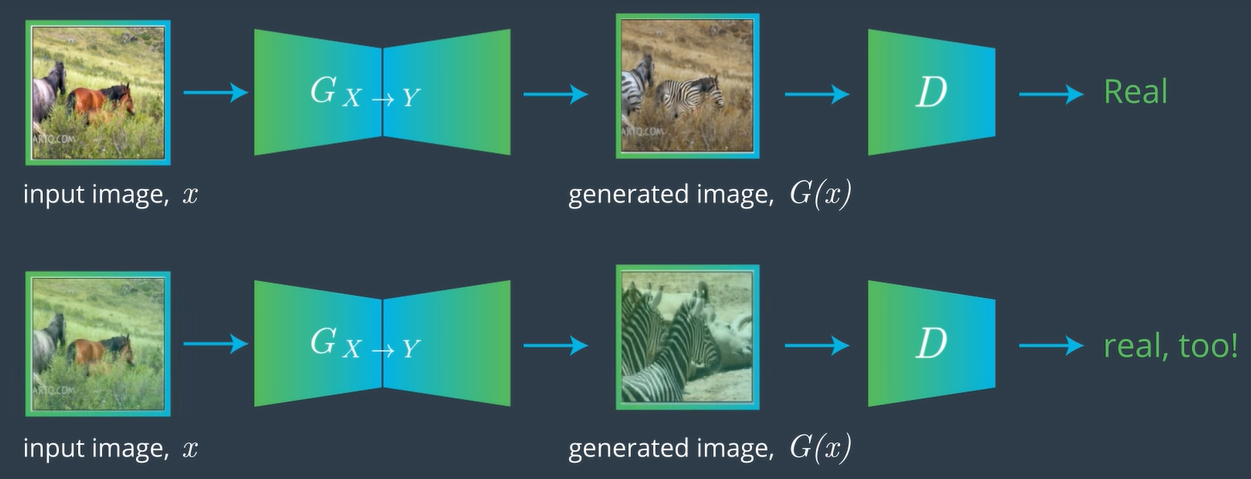

## 2.0 Pix2Pix GAN

Pix2Px generative Adversarial Network

https://machinelearningmastery.com/a-gentle-introduction-to-pix2pix-generative-adversarial-network/

## DATA LOADER

In [18]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
!unzip -o -q summer2winter-yosemite.zip

--2020-03-04 11:08:49--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.248.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.248.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip.2’

summer2winter-yosem 100%[===================>] 127.58M  35.2MB/s    in 4.2s    

2020-03-04 11:08:54 (30.4 MB/s) - ‘summer2winter-yosemite.zip.2’ saved [133783376/133783376]



In [0]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [0]:
# Create train and test dataloaders for images from the two domains X and Y
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

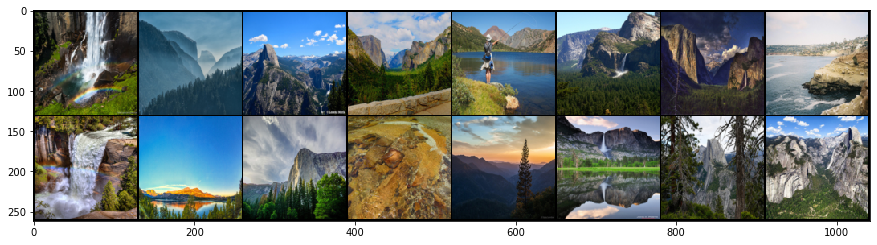

In [13]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(15, 8))
imshow(torchvision.utils.make_grid(images))

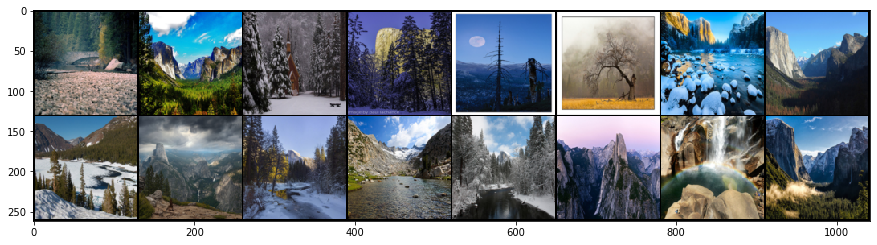

In [15]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(15,8))
imshow(torchvision.utils.make_grid(images))

## 4.0 SCALING IMAGE

In [16]:

# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(0.9333)


In [17]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x


# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(0.8667)


## 4.0 IMAGE

In [0]:

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.layer_1 = conv(3,conv_dim,4,batch_norm = False)
        self.layer_2 = conv(conv_dim,conv_dim*2,4)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4)
        self.layer_4 = conv(conv_dim*4,conv_dim*8,4)
        self.layer_5 = conv(conv_dim*8,1,4,1,batch_norm = False)

    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = F.relu(self.layer_4(x))
        
        x = self.layer_5(x)
        return x

In [0]:
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.layer_1 = conv(conv_dim,conv_dim,3,1,1,batch_norm = True)
        self.layer_2 = conv(conv_dim,conv_dim,3,1,1,batch_norm = True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.layer_1(x))
        out_2 = x + self.layer_2(out_1)
        
        return out_2

In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)
    
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.layer_1 = conv(3,conv_dim,4)
        self.layer_2 = conv(conv_dim,conv_dim*2,4)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4)
        # 2. Define the resnet part of the generator
        layers = []
        for n in range(n_res_blocks):
            layers.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*layers)
        # 3. Define the decoder part of the generator
        self.layer_4 = deconv(conv_dim*4,conv_dim*2,4)
        self.layer_5 = deconv(conv_dim*2,conv_dim,4)
        self.layer_6 = deconv(conv_dim,3,4,batch_norm = False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        
        out = F.relu(self.layer_1(x))
        out = F.relu(self.layer_2(out))
        out = F.relu(self.layer_3(out))
        
        out = self.res_blocks(out)
        
        out = F.relu(self.layer_4(out))
        out = F.relu(self.layer_5(out))
        out = F.tanh(self.layer_6(out))
        
        return out

In [0]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(g_conv_dim,n_res_blocks)
    G_YtoX = CycleGenerator(g_conv_dim,n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)
    

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [22]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [23]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (layer_1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

# 06. LOSS

In [0]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out - 1)**2)

    
def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return loss*lambda_weight

# 07. OPTIMIZER

In [0]:
# hyperparams for Adam optimizers
import torch.optim as optim

lr= 0.0002
beta1= 0.5
beta2= 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

# 10. HELPERS

In [30]:
# helper functions for saving sample data and models
!mkdir samples_cyclegan

# import data loading libraries
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    scipy.misc.imsave(path, merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    scipy.misc.imsave(path, merged)
    print('Saved {}'.format(path))

mkdir: cannot create directory ‘samples_cyclegan’: File exists


# 11 TRAIN

In [0]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # 1. Compute the discriminator losses on real images
        d_x_optimizer.zero_grad()
        real_D_loss = real_mse_loss(D_X(images_X))
        # 3. Compute the fake loss for D_X
        fake_D_loss = fake_mse_loss(D_X(G_YtoX(images_Y)))
        # 4. Compute the total loss and perform backprop
        d_x_loss = real_D_loss + fake_D_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()
        real_D_y_loss = real_mse_loss(D_Y(images_Y))
        
        fake_D_y_loss = fake_mse_loss(D_Y(G_XtoY(images_X)))
        
        d_y_loss = real_D_y_loss + fake_D_y_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
        # 1. Generate fake images that look like domain X based on real images in domain Y
        out_1 = G_YtoX(images_Y)
        # 2. Compute the generator loss based on domain X
        loss_1 = real_mse_loss(D_X(out_1))
        # 3. Create a reconstructed y
        out_2 = G_XtoY(out_1)
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        loss_2 = cycle_consistency_loss(real_im = images_Y, reconstructed_im = out_2, lambda_weight=10)

        ##    Second: generate fake Y images and reconstructed X images    ##
        out_3 = G_XtoY(images_X)
        # 5. Add up all generator and reconstructed losses and perform backprop
        loss_3 = real_mse_loss(D_Y(out_3))
        out_4 = G_YtoX(out_3)
        loss_4 =  cycle_consistency_loss(real_im = images_X, reconstructed_im = out_4, lambda_weight=10)

        g_total_loss = loss_1 + loss_2 + loss_3 + loss_4
        g_total_loss.backward()
        g_optimizer.step()
        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [31]:

n_epochs = 5000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, 
                       dataloader_Y, 
                       test_dataloader_X, test_dataloader_Y,
                       n_epochs=n_epochs)

Epoch [   10/ 5000] | d_X_loss: 0.3198 | d_Y_loss: 0.5804 | g_total_loss: 9.1308
Epoch [   20/ 5000] | d_X_loss: 0.1348 | d_Y_loss: 0.4823 | g_total_loss: 8.3546
Epoch [   30/ 5000] | d_X_loss: 0.2266 | d_Y_loss: 0.2318 | g_total_loss: 7.8895
Epoch [   40/ 5000] | d_X_loss: 0.4452 | d_Y_loss: 0.4189 | g_total_loss: 7.5426
Epoch [   50/ 5000] | d_X_loss: 0.8201 | d_Y_loss: 0.6043 | g_total_loss: 5.2557
Epoch [   60/ 5000] | d_X_loss: 0.4632 | d_Y_loss: 0.5105 | g_total_loss: 6.0895
Epoch [   70/ 5000] | d_X_loss: 0.3497 | d_Y_loss: 0.6091 | g_total_loss: 4.5316
Epoch [   80/ 5000] | d_X_loss: 0.2651 | d_Y_loss: 0.4583 | g_total_loss: 4.8702
Epoch [   90/ 5000] | d_X_loss: 0.3335 | d_Y_loss: 0.9023 | g_total_loss: 5.7078
Epoch [  100/ 5000] | d_X_loss: 0.6943 | d_Y_loss: 0.4701 | g_total_loss: 4.8585
Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 5000] | d_X_loss: 0.4326 | d_Y_loss: 0.4573 | g_total_loss: 5.3399
Epoch [  120/ 5000]

# 12. EVALUATE

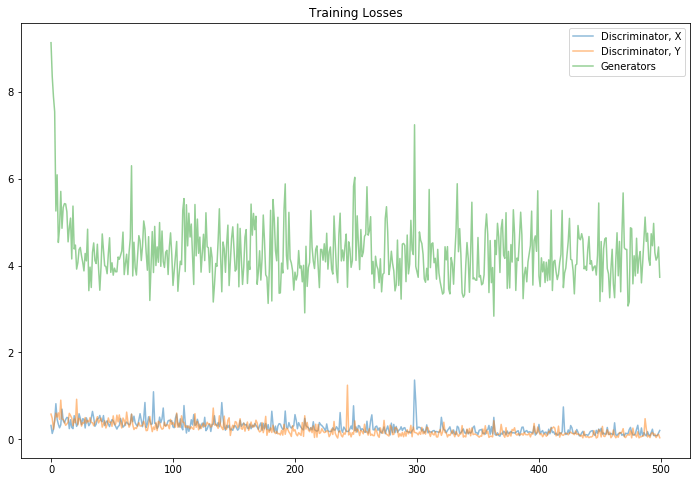

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

# 13. TEST

In [0]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

# view samples at iteration 100
view_samples(1, 'samples_cyclegan')